In [2]:
import pandas as pd
from Bio import motifs

import numpy as np
import sys, os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib

# format matplotlib
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2.5
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.minor.width'] = 1
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = 'Arial'

## Figure 1B: size heterogeineity in DNA and RNA library

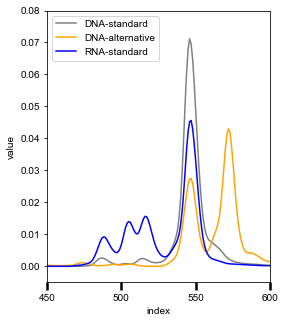

In [3]:
# read tape station data for standard protocol
df = pd.read_csv('data/2023-08-04 - 12-17-54-D1000_Electropherogram.csv', sep = ',')
df = df.reset_index()

dnacol = 'C1: DNA-3'
rnacol = 'D1: RNA-1'

toplot = df[['index', dnacol, rnacol]].reset_index(drop=True)

# normalize peak by area under the line
toplot['DNA-standard'] = toplot[dnacol]/np.trapz(toplot.iloc[200:600][dnacol].to_numpy(), dx=1)
toplot['RNA-standard'] = toplot[rnacol]/np.trapz(toplot.iloc[200:600][rnacol].to_numpy(), dx=1)
# convert DF from wide to long
toplot = pd.melt(toplot, value_vars = ['DNA-standard', 'RNA-standard'], id_vars = 'index')

# read tape station data for alternative protocol
df = pd.read_csv('data/2025-03-16 - DNA RNA gel_Electropherogram.csv', sep = ',')
df = df.reset_index()
df['index'] = df['index'] + 45

dnacol = 'A2: PTREseq_DNA_UTR'
rnacol = 'B2: PTREseq_RNA_UTR'

toplot1 = df[['index', dnacol, rnacol]].reset_index(drop=True)

# normalize peak by area under the line
toplot1['DNA-alternative'] = toplot1[dnacol]/np.trapz(toplot1.iloc[200:600][dnacol].to_numpy(), dx=1)
#toplot1['RNA'] = toplot1[rnacol]/np.trapz(toplot1.iloc[200:600][rnacol].to_numpy(), dx=1)
# convert DF from wide to long
toplot1 = pd.melt(toplot1, value_vars = ['DNA-alternative'], id_vars = 'index')

# merge both protocols
m = pd.concat([toplot, toplot1]).reset_index(drop = True)

# plot normalized electropherogram 
f, ax = plt.subplots(figsize = (4, 5))

sns.lineplot(data = m, x = 'index', y = 'value', hue = 'variable', 
             hue_order = ['DNA-standard', 'DNA-alternative', 'RNA-standard'],
             palette = ['grey', 'orange', 'blue'], ax = ax)

ax.set_xlim(460, 600)
ax.set_ylim(-0.005, 0.08)
ax.legend(title = '', loc = 'upper left')

ax.set_xticks([i for i in range(450, 650, 50)])

#f.savefig('PLOTS/Fig_tape_station_normalized_by_area_palindrome.pdf')

## Figure 1D: Sequence logo of splice junctions

In [8]:
import logomaker

donor_xlabels = ['-3', '-2', '-1', '+1', '+2', '+3', '+4', '+5', '+6']
acceptor_xlabels = ['-20', '-19', '-18', '-17', '-16', '-15', 
                    '-14', '-13', '-12', '-11', '-10', '-9',
                   '-8', '-7', '-6', '-5', '-4', '-3', '-2',
                   '-1', '+1', '+2', '+3']

def plot_logo(asdf, figsize, xlabels, out=None):
    # function to plot sequence logo

    f, ax = plt.subplots(figsize = figsize)

    ss_logo = logomaker.Logo(asdf,
                             width=.7,
                             vpad=.05,
                             fade_probabilities=True,
                             stack_order='small_on_top',
                             font_name='Arial Rounded MT Bold',
                             ax = ax
                            )

    # style using Logo methods
    ss_logo.style_spines(
        spines=[
            'left', 
            'right'
        ], 
        visible=False
    )

    # style using Axes methods
    ss_logo.ax.set_xticks(range(len(asdf)))
    ss_logo.ax.set_xticklabels(xlabels)
    
    ss_logo.ax.set_yticks([0, .5, 1])
    #ss_logo.ax.axvline(11.5, color='k', linewidth=1, linestyle=':')
    ss_logo.ax.set_ylabel('probability', fontsize=14)
    
    if out:
        f.savefig(out, transparent = True)

In [9]:
# read gaps data
_gaps = pd.read_csv('data/HELA-1_gap_sequences.txt.gz', sep = '\t', compression = 'gzip',
                  names = ['read', 'cigar', 'five', 'three', 'len', 'check'])

gaps = _gaps[_gaps['check']=='pass'] # filter out very short gaps
gaps = gaps.dropna()
gaps = gaps[gaps['len']>1]
gaps = gaps[(gaps['five'].str.len()==9)&(gaps['three'].str.len()==23)]
gaps = gaps[(gaps['five'].str.contains('^[^a-z]+$'))&
            (gaps['three'].str.contains('^[^a-z]+$'))]

five = gaps['five'].to_list()
three = gaps['three'].to_list()

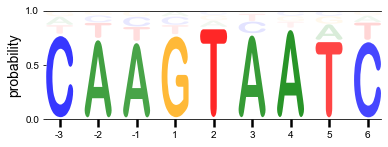

In [12]:
# plot 5'ss sequence logo for PTRE-seq
m = motifs.create(five)
m_df = pd.DataFrame(m.counts)
m_pwm = m_df.divide(m_df.sum(axis=1)[0])

donor_xlabels = [-3, -2, -1, +1, +2, +3, +4, +5, +6]
plot_logo(m_pwm, (6, 2), donor_xlabels)

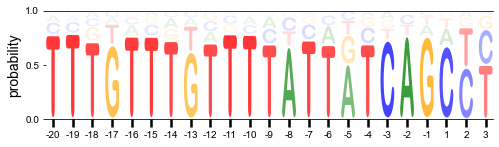

In [13]:
# plot 3'ss sequence logo
m = motifs.create(three)
m_df = pd.DataFrame(m.counts)
m_pwm = m_df.divide(m_df.sum(axis=1)[0])

donor_xlabels = [-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, 
                 -9, -8, -7, -6, -5, -4, -3, -2, -1, +1, +2, +3]
plot_logo(m_pwm, (8, 2), donor_xlabels)

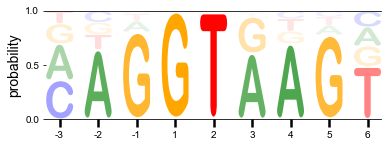

In [14]:
# plot 5'ss sequence logo for human ss
# fasta file is compressed in gzip format. Unzip before use.

human_5ss = []

with open('data/human_5ss_sequence.fa', 'r') as fn:
    for line in fn:
        if line.startswith('>'):
            continue
        else:
            human_5ss.append(line.rstrip())

m = motifs.create(human_5ss)
m_df = pd.DataFrame(m.counts)
m_pwm = m_df.divide(m_df.sum(axis=1)[0])

donor_xlabels = [-3, -2, -1, +1, +2, +3, +4, +5, +6]
plot_logo(m_pwm, (6, 2), donor_xlabels)

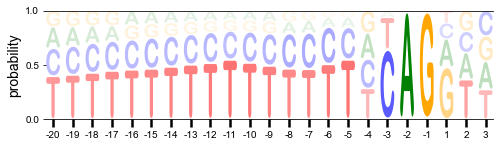

In [15]:
# plot 3'ss sequence logo for human ss
# fasta file is compressed in gzip format. Unzip before use.

human_3ss = []

with open('data/human_3ss_sequence.fa', 'r') as fn:
    for line in fn:
        if line.startswith('>'):
            continue
        else:
            human_3ss.append(line.rstrip())

# plot 3'ss sequence logo
m = motifs.create(human_3ss)
m_df = pd.DataFrame(m.counts)
m_pwm = m_df.divide(m_df.sum(axis=1)[0])

donor_xlabels = [-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, 
                 -9, -8, -7, -6, -5, -4, -3, -2, -1, +1, +2, +3]
plot_logo(m_pwm, (8, 2), donor_xlabels)

## Figure 1E: changed to figure S1C, see F1S_splicing_reproducibility.ipynb

In [4]:
"""
def change_cat_name(cat):
    if cat == 'full_length':
        return cat
    elif 'spliced' in cat:
        return 'spliced'
    else:
        return 'unassigned'

def get_count(fn):
    df = pd.read_csv(fn, sep = '\t')
    df['best_category'] = df['best_category'].apply(lambda g: change_cat_name(g))
    dfcount = df.groupby('best_category')['count'].sum()
    dfper = dfcount/dfcount.sum()
    return dfper
    
# calculate fraction of full length, spliced, and unassigned reads for DNA sample
dna1 = get_count('ptreseq_raw_count/DNA-1_raw_count.txt')
dna2 = get_count('ptreseq_raw_count/DNA-2_raw_count.txt')
dna_mean = pd.concat([dna1, dna2], axis=1).mean(axis = 1)
dna_std = pd.concat([dna1, dna2], axis=1).std(axis = 1)

# calculate fraction of full length, spliced, and unassigned reads for RNA sample (hela SSII)
hela1 = get_count('ptreseq_raw_count/HELA-1_raw_count.txt')
hela2 = get_count('ptreseq_raw_count/HELA-2_raw_count.txt')
hela_mean = pd.concat([hela1, hela2], axis=1).mean(axis = 1)
hela_std = pd.concat([hela1, hela2], axis=1).std(axis = 1)

# calculate fraction of full length, spliced, and unassigned reads for RNA sample (hek293 SSII)
hek1 = get_count('ptreseq_raw_count/HEK-1_raw_count.txt')
hek2 = get_count('ptreseq_raw_count/HEK-2_raw_count.txt')
hek3 = get_count('ptreseq_raw_count/HEK-3_raw_count.txt')
hek_mean = pd.concat([hek1, hek2, hek3], axis=1).mean(axis = 1)
hek_std = pd.concat([hek1, hek2, hek3], axis=1).std(axis = 1)

# calculate fraction of full length, spliced, and unassigned reads for RNA sample (sh-s5y5 SSII)
sh1 = get_count('ptreseq_raw_count/SH-1_raw_count.txt')
sh2 = get_count('ptreseq_raw_count/SH-2_raw_count.txt')
sh3 = get_count('ptreseq_raw_count/SH-3_raw_count.txt')
sh_mean = pd.concat([sh1, sh2, sh3], axis=1).mean(axis = 1)
sh_std = pd.concat([sh1, sh2, sh3], axis=1).std(axis = 1)

# calculate fraction of full length, spliced, and unassigned reads for RNA sample (u87 SSII)
u871 = get_count('ptreseq_raw_count/U87-1_raw_count.txt')
u872 = get_count('ptreseq_raw_count/U87-2_raw_count.txt')
u873 = get_count('ptreseq_raw_count/U87-3_raw_count.txt')
u87_mean = pd.concat([u871, u872, u873], axis=1).mean(axis = 1)
u87_std = pd.concat([u871, u872, u873], axis=1).std(axis = 1)

# calculate fraction of full length, spliced, and unassigned reads for RNA sample (hela marathon)
#mara1 = get_count('ptreseq_raw_count/ETOH-1_raw_count.txt')
#mara2 = get_count('ptreseq_raw_count/ETOH-2_raw_count.txt')
#mara_mean = pd.concat([mara1, mara2], axis=1).mean(axis = 1)
#mara_std = pd.concat([mara1, mara2], axis=1).std(axis = 1)
"""

In [1]:
"""
# plot stacked bar chart
f, ax = plt.subplots()

bottom = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

for col, color in zip(['full_length', 'spliced', 'unassigned'], ['green', 'blue', 'grey']):
    ax.bar(
        ['DNA', 'HELA', 'HEK293', 'SH-S5Y5', 'U87'], 
        [dna_mean[col], hela_mean[col], hek_mean[col], sh_mean[col], u87_mean[col]], 
        yerr = [dna_std[col], hela_std[col], hek_std[col], sh_std[col], u87_std[col]],
        bottom = bottom, 
        width = 0.45,
        color = color,
        error_kw = {'xlolims': True, 'capsize': 5}
    )

    bottom += np.array([dna_mean[col], hela_mean[col], hek_mean[col], sh_mean[col], u87_mean[col]])

ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels(['0%', '50%', '100%'])
    
f.savefig('PLOTS/Fig_1E_DNA_RNA_full_length_spliced_artifact.pdf')
"""

"\n# plot stacked bar chart\nf, ax = plt.subplots()\n\nbottom = np.array([0.0, 0.0, 0.0, 0.0, 0.0])\n\nfor col, color in zip(['full_length', 'spliced', 'unassigned'], ['green', 'blue', 'grey']):\n    ax.bar(\n        ['DNA', 'HELA', 'HEK293', 'SH-S5Y5', 'U87'], \n        [dna_mean[col], hela_mean[col], hek_mean[col], sh_mean[col], u87_mean[col]], \n        yerr = [dna_std[col], hela_std[col], hek_std[col], sh_std[col], u87_std[col]],\n        bottom = bottom, \n        width = 0.45,\n        color = color,\n        error_kw = {'xlolims': True, 'capsize': 5}\n    )\n\n    bottom += np.array([dna_mean[col], hela_mean[col], hek_mean[col], sh_mean[col], u87_mean[col]])\n\nax.set_yticks([0, 0.5, 1.0])\nax.set_yticklabels(['0%', '50%', '100%'])\n    \nf.savefig('PLOTS/Fig_1E_DNA_RNA_full_length_spliced_artifact.pdf')\n"

## Figure 1F: histogram of spliced fraction distribution

In [4]:
# function to calculate splicing fraction
def cal_splicing_fraction(fn):
    df = pd.read_csv(fn, sep = '\t')
    df['spliced_fraction'] = 1 - df['fraction']
    df_full = df[df['best_category']=='full_length']
    return df_full

DNA = cal_splicing_fraction('ptreseq_splicing_quantification/DNA_2rep_fraction.txt')
HELA = cal_splicing_fraction('ptreseq_splicing_quantification/HELA_2rep_fraction.txt')
HEK = cal_splicing_fraction('ptreseq_splicing_quantification/HEK_3rep_fraction.txt')
U87 = cal_splicing_fraction('ptreseq_splicing_quantification/U87_3rep_fraction.txt')
SH = cal_splicing_fraction('ptreseq_splicing_quantification/SH_3rep_fraction.txt')

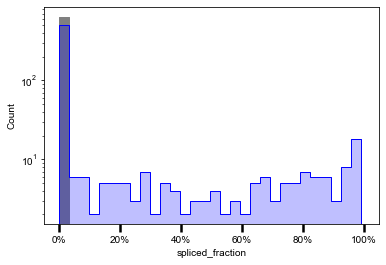

In [5]:
# Plot histogram for DNA plasmid and RNA from HeLa
f, ax = plt.subplots()

sns.histplot(data = DNA, x = 'spliced_fraction', element = 'step', 
             bins = 30, color = 'grey', alpha = 1.0, ax = ax)
sns.histplot(data = HELA, x = 'spliced_fraction', element = 'step', 
             bins = 30, color = 'blue', alpha = 0.25, ax = ax)

ax.set_yscale('log')
ax.set_xlim(-0.05, 1.05)

ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

f.savefig('PLOTS/Fig_1F_histogram_HELA_DNA_splicing_fraction.pdf', transparent = True)

## Figure 1G: comparison of splicing efficiency between cell lines

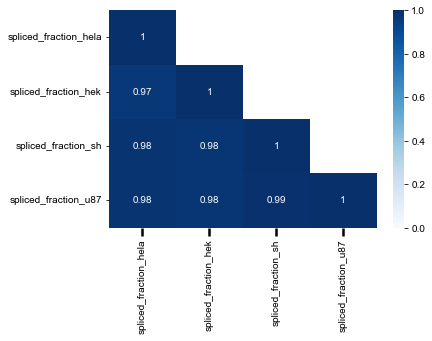

In [6]:
# merge all cell lines into 1 dataframe
hela_hek = HELA[['RE', 'spliced_fraction']].merge(
    HEK[['RE', 'spliced_fraction']], on = 'RE', suffixes = ('_hela', '_hek'))
sh_u87 = SH[['RE', 'spliced_fraction']].merge(
    U87[['RE', 'spliced_fraction']], on = 'RE', suffixes = ('_sh', '_u87'))

combined = hela_hek.merge(sh_u87, on = 'RE')

# calculate pearson correlation
correlation = combined.corr()

# plot heat map
f, ax = plt.subplots()

mask = np.array([[False, True, True, True],
       [False, False, True, True],
       [False, False, False, True],
       [False, False, False, False]])

sns.heatmap(data = correlation, annot = True, mask = mask,
            vmin = 0, cmap = 'Blues', ax = ax)

f.savefig('PLOTS/Fig_1G_cell_line_heatmap.pdf', transparent = True)